In [1]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

In [2]:
openmeteo = openmeteo_requests.Client(
    session = requests_cache.CachedSession(
        cache_name='openmeteo_cache',
        backend='memory'
    )
)
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 37.000495,
	"longitude": -86.36811,
	"hourly": ["shortwave_radiation", "shortwave_radiation_instant", "cloud_cover"],
	"minutely_15": ["shortwave_radiation_instant", "shortwave_radiation"],
}
responses = openmeteo.weather_api(url, params=params)

In [3]:
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

Coordinates: 36.98920440673828°N -86.37091827392578°E
Elevation: 163.0 m asl
Timezone difference to GMT+0: 0s


In [4]:
hourly = response.Hourly()
hourly_shortwave_radiation = hourly.Variables(0).ValuesAsNumpy()
hourly_shortwave_radiation_instant = hourly.Variables(1).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()

In [5]:
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

In [6]:
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
hourly_data["cloud_cover"] = hourly_cloud_cover

In [7]:
hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)


Hourly data
                          date  shortwave_radiation  \
0   2025-11-18 00:00:00+00:00                  0.0   
1   2025-11-18 01:00:00+00:00                  0.0   
2   2025-11-18 02:00:00+00:00                  0.0   
3   2025-11-18 03:00:00+00:00                  0.0   
4   2025-11-18 04:00:00+00:00                  0.0   
..                        ...                  ...   
163 2025-11-24 19:00:00+00:00                303.0   
164 2025-11-24 20:00:00+00:00                234.0   
165 2025-11-24 21:00:00+00:00                155.0   
166 2025-11-24 22:00:00+00:00                 76.0   
167 2025-11-24 23:00:00+00:00                 14.0   

     shortwave_radiation_instant  cloud_cover  
0                       0.000000          0.0  
1                       0.000000          0.0  
2                       0.000000          1.0  
3                       0.000000          0.0  
4                       0.000000          7.0  
..                           ...          ...  
1

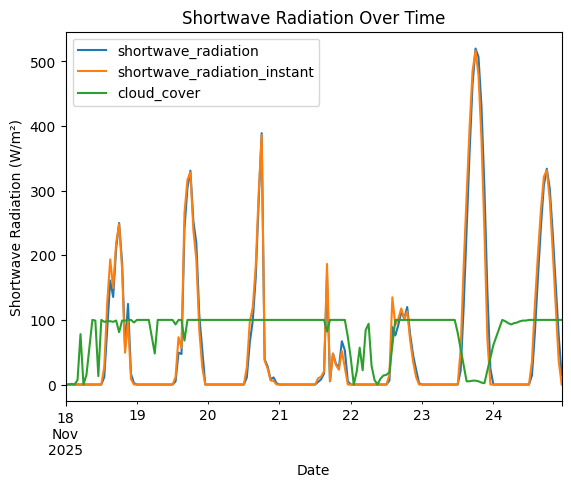

In [8]:
# plot the data
import matplotlib.pyplot as plt
hourly_dataframe.set_index("date").plot(y = ["shortwave_radiation", "shortwave_radiation_instant", "cloud_cover"])
plt.xlabel("Date")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.title("Shortwave Radiation Over Time")
plt.legend()
plt.show()

,shortwave_radiation,shortwave_radiation_instant,cloud_cover
date,,,
2025-11-18 10:00:00-06:00,135.500000,149.290451,97.000000
2025-11-18 10:01:00-06:00,136.708191,150.455566,97.033333
2025-11-18 10:02:00-06:00,137.903793,151.609207,97.066666
2025-11-18 10:03:00-06:00,139.106781,152.768707,97.099998
2025-11-18 10:04:00-06:00,140.316833,153.933777,97.133331
...,...,...,...
2025-11-18 17:56:00-06:00,4.222099,3.480126,99.733330
2025-11-18 17:57:00-06:00,3.269992,2.700606,99.800003
2025-11-18 17:58:00-06:00,2.262755,1.874490,99.866669


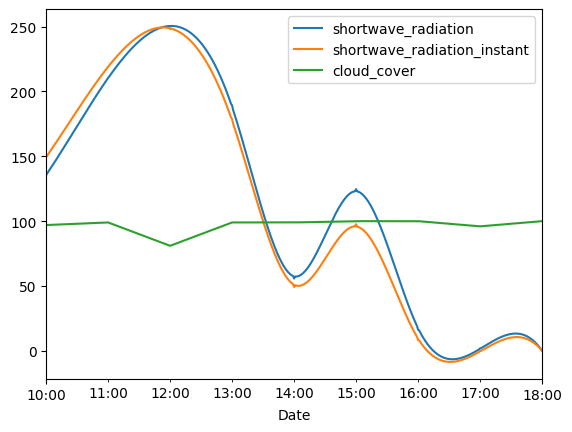

In [ ]:
# extract the shortwave radiation from earliest 10am to 6pm in central time, only first day
# then plot it
import matplotlib.pyplot as plt
central_timezone = "America/Chicago"
hourly_dataframe_central = hourly_dataframe.set_index("date").tz_convert(central_timezone)
daytime_data = hourly_dataframe_central.between_time("10:00", "18:00")
daytime_data = daytime_data[1:10]  # first day only
daytime_data = daytime_data.reset_index()
# resample to 1 minute intervals
daytime_data = daytime_data.resample("min", on="date").mean()
# interpolate shortwave radiation columns with cubic spline
daytime_data["shortwave_radiation"] = daytime_data["shortwave_radiation"].interpolate(method="spline", order=3)
daytime_data["shortwave_radiation_instant"] = daytime_data["shortwave_radiation_instant"].interpolate(method="spline", order=3)
# interpolate cloud cover linearly
daytime_data["cloud_cover"] = daytime_data["cloud_cover"].interpolate(method="linear")
daytime_data.plot(y = ["shortwave_radiation", "shortwave_radiation_instant", "cloud_cover"])
plt.xlabel("Date")
daytime_data